In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import random
import re
import json
import threading
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import gc
import os
import time
from datetime import datetime, time as dt_time
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import r2_score

In [3]:
def convert_to_json(row):
    id = row[0]
    date = row[1]
    details = json.loads(row[2])
    summary = json.loads(row[3])
    return pd.DataFrame([[id, date, details, summary]], columns=['Id', 'Date', 'Details', 'Summary'])

In [4]:
def create_threads_for_rows(data):
    threads = []
    results = []

    def thread_function(index, row):
        processed_row = convert_to_json(row)
        results.append(processed_row)

    num_rows = data.shape[0]
    for i in range(num_rows):
        row = data.iloc[i, :]
        thread = threading.Thread(target=thread_function, args=(i, row))
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    processed_data = pd.concat(results, ignore_index=True)
    return processed_data

In [5]:
def parse_data(row):
    #global columnset
    columnset = pd.read_csv('/content/drive/MyDrive/Final Project/columnset.csv').values.flatten().tolist()
    id = row.values[0][0]
    date = row.values[0][1]
    nutritions_data = row.values[0][2]

    rows = []

    for meal_data in nutritions_data:
        sequence = meal_data.get('sequence', np.nan)
        meal_name = meal_data.get('meal', np.nan)
        dishes = meal_data.get('dishes', [])

        for dish in dishes:
            dish_name = dish.get('name', np.nan)
            nutritions_list = dish.get('nutritions', [])

            nutrients = {
                'Calcium': np.nan,
                'Calories': np.nan,
                'Carbs': np.nan,
                'Chol': np.nan,
                'Fat': np.nan,
                'Fiber': np.nan,
                'Iron': np.nan,
                'Mon Fat': np.nan,
                'Ply Fat': np.nan,
                'Potass.': np.nan,
                'Protein': np.nan,
                'Sat Fat': np.nan,
                'Sodium': np.nan,
                'Sugar': np.nan,
                'Trn Fat': np.nan,
                'Vit A': np.nan,
                'Vit C': np.nan
            }

            for nutrition in nutritions_list:
                nutrient_name = nutrition.get('name', '')
                if nutrient_name in nutrients:
                    nutrients[nutrient_name] = nutrition.get('value', np.nan)
                else:
                    print(f"Unexpected nutrient: {nutrient_name}")

            row_data = {
                columnset[0]: id,
                'Date': date,
                'Sequence': sequence,
                'MealName': meal_name,
                'DishName': dish_name,
                f"{columnset[4]}_value": nutrients['Calcium'],
                f"{columnset[5]}_value": nutrients['Calories'],
                f"{columnset[6]}_value": nutrients['Carbs'],
                f"{columnset[7]}_value": nutrients['Chol'],
                f"{columnset[8]}_value": nutrients['Fat'],
                f"{columnset[9]}_value": nutrients['Fiber'],
                f"{columnset[10]}_value": nutrients['Iron'],
                f"{columnset[11]}_value": nutrients['Mon Fat'],
                f"{columnset[12]}_value": nutrients['Ply Fat'],
                f"{columnset[13]}_value": nutrients['Potass.'],
                f"{columnset[14]}_value": nutrients['Protein'],
                f"{columnset[15]}_value": nutrients['Sat Fat'],
                f"{columnset[16]}_value": nutrients['Sodium'],
                f"{columnset[17]}_value": nutrients['Sugar'],
                f"{columnset[18]}_value": nutrients['Trn Fat'],
                f"{columnset[19]}_value": nutrients['Vit A'],
                f"{columnset[20]}_value": nutrients['Vit C'],
            }

            rows.append(row_data)

    df = pd.DataFrame(rows)
    return df

In [6]:
def parse_data_total_goal(row):
    totals = row.values[0][3].get('total', [])
    goals = row.values[0][3].get('goal', [])

    totals_dict = {
        'Calcium_total': np.nan,
        'Calories_total': np.nan,
        'Carbs_total': np.nan,
        'Chol_total': np.nan,
        'Fat_total': np.nan,
        'Fiber_total': np.nan,
        'Iron_total': np.nan,
        'Mon Fat_total': np.nan,
        'Ply Fat_total': np.nan,
        'Potass._total': np.nan,
        'Protein_total': np.nan,
        'Sat Fat_total': np.nan,
        'Sodium_total': np.nan,
        'Sugar_total': np.nan,
        'Trn Fat_total': np.nan,
        'Vit A_total': np.nan,
        'Vit C_total': np.nan
    }

    goals_dict = {key.replace('_total', '_goal'): value for key, value in totals_dict.items()}

    for total in totals:
        name = total.get('name', '')
        value = total.get('value', np.nan)
        total_name = name + '_total'
        if total_name in totals_dict:
            totals_dict[total_name] = value

    for goal in goals:
        name = goal.get('name', '')
        value = goal.get('value', np.nan)
        goal_name = name + '_goal'
        if goal_name in goals_dict:
            goals_dict[goal_name] = value

    totals_df = pd.DataFrame([totals_dict])
    goals_df = pd.DataFrame([goals_dict])

    both = pd.concat([totals_df, goals_df], axis=1)
    return both

In [7]:
def create_threads_for_processing(data):
    threads = []
    results = []

    def thread_function(index, row):
        row = create_threads_for_rows(data.iloc[[i], :])
        processed_row_1 = parse_data(row)
        processed_row_2 = parse_data_total_goal(row)
        duplicated_df = pd.concat([processed_row_2] * processed_row_1.shape[0], ignore_index=True)
        processed_row = pd.concat([processed_row_1, duplicated_df], axis=1)
        results.append(processed_row)
    num_rows = data.shape[0]
    for i in range(num_rows):
        row = data.iloc[[i], :]
        thread = threading.Thread(target=thread_function, args=(i, row))
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    processed_data = pd.concat(results, ignore_index=True)
    return processed_data

In [8]:
def for_test(test):
  processd_rows = create_threads_for_processing(test)
  processd_rows.sort_values(by=['Id', 'Date'], inplace=True)
  return processd_rows

In [9]:
def process_MealName_column(meal_name):
  data = meal_name.copy()
  del meal_name
  data['MealName'] = data['MealName'].str.lower()

  data['MealName'] = data['MealName'].str.replace(r'[^a-zA-Z0-9\s:]', '', regex=True)
  data['MealName'] = data['MealName'].str.replace(r'th|rd|st|nd|#', '', regex=True)
  data['MealName'] = data['MealName'].str.replace(r'\s+', ' ', regex=True)


  breakfast_keywords = ['morni', 'first', 'break', 'wake up', 'meal 1', 'meal 2', 'meal one', 'meal two', '1 meal', '2 meal', 'one meal', 'two meal', 'one', 'two', 'early']
  lunch_keywords = ['afternoon', 'noon', 'lunch', 'mid', 'meal 3', 'meal 4', 'meal three', 'meal four', '3 meal', '4 meal', 'three meal', 'four meal', 'final', 'four', 'three']
  dinner_keywords = ['dinner','sleep', 'supper', 'evening', 'night', 'late', 'bedtime', 'before bed', 'meal 5', 'meal 6', 'meal five', 'meal six', '5 meal', '6 meal', 'five meal', 'six meal', 'five', 'six']
  snack_keywords = ['snack', 'desert', 'sweet']
  drinks_keywords = ['drink', 'tea', 'coffee', 'liquid', 'alcohol', 'beverage', 'fluid']
  supplement_keywords = ['supplement', 'vitamin', 'pill', 'protein', 'addition']
  workout_keywords = ['workout', 'work']


  meal_names = data['MealName'].values

  def convert_to_time_format(text):
      pattern = re.compile(r'(\d{1,2})(:?\d{2})?\s*(am|pm)?', flags=re.IGNORECASE)
      matches = pattern.findall(text.lower())

      if matches:
          times = []
          for match in matches:
              hour = int(match[0])
              minute = int(match[1][1:]) if match[1] else 0
              period = match[2].lower() if match[2] else None

              if period:
                  if 1 <= hour <= 12:
                      if period == 'pm' and hour < 12:
                          hour += 12
                      elif period == 'am' and hour == 12:
                          hour = 0
              else:
                  if hour == 24 and minute == 0:
                      hour = 0
                  elif hour >= 24 or minute >= 60:
                      continue

              times.append((hour, minute))

          if times:
              return times

      return None

  def date_in_range(meal_name, meal_type):
      times = convert_to_time_format(meal_name)

      if times:
          for hour, minute in times:
              if meal_type == 'breakfast' and (4 <= hour < 12 or (hour == 12 and minute == 0)):
                  return True
              elif meal_type == 'lunch' and (12 <= hour < 18 or (hour == 18 and minute == 0)):
                  return True
              elif meal_type == 'dinner' and (18 <= hour <= 23 or (hour == 0 and minute == 0)):
                  return True

              if meal_type == 'breakfast' and (hour in range(1, 13) or hour == 0) and 'am' in meal_name:
                  return True

      return False


  categorized_meal_names = []

  for meal_name in meal_names:
      lower_case_meal_name = meal_name.lower()

      if any(keyword in lower_case_meal_name for keyword in breakfast_keywords) or date_in_range(lower_case_meal_name, 'breakfast'):
          categorized_meal_names.append('breakfast')
          continue

      if any(keyword in lower_case_meal_name for keyword in lunch_keywords) or date_in_range(lower_case_meal_name, 'lunch'):
          categorized_meal_names.append('lunch')
          continue

      if any(keyword in lower_case_meal_name for keyword in dinner_keywords) or date_in_range(lower_case_meal_name, 'dinner'):
          categorized_meal_names.append('dinner')
          continue

      if any(keyword in lower_case_meal_name for keyword in snack_keywords):
          categorized_meal_names.append('snack')
          continue

      if any(keyword in lower_case_meal_name for keyword in drinks_keywords):
          categorized_meal_names.append('drinks')
          continue

      if any(keyword in lower_case_meal_name for keyword in supplement_keywords):
          categorized_meal_names.append('supplement')
          continue

      if any(keyword in lower_case_meal_name for keyword in workout_keywords):
          categorized_meal_names.append('workout')
          continue
      categorized_meal_names.append(meal_name)

  data['MealName'] = categorized_meal_names


  condition = [
    (data['MealName'] == 'breakfast'),
    (data['MealName'] == 'lunch'),
    (data['MealName'] == 'dinner'),
    (data['MealName'] == 'snack'),
    (data['MealName'] == 'drinks'),
    (data['MealName'] == 'supplement'),
    (data['MealName'] == 'workout'),

  ]
  choices = [
      'breakfast',
      'lunch',
      'dinner',
      'snack',
      'drinks',
      'supplement',
      'workout',
  ]

  data['MealName'] = np.select(condition, choices, default='unknown')
  return data

In [10]:
def convert_objects_into_numeric(data):
  colls = data.columns
  colls_to_check = colls[11:]
  for col in colls_to_check:
    if data[col].dtype == 'object':
      data[col] = pd.DataFrame(data[col]).apply(lambda x: x.str.replace(',', '.').str.replace(r'\.(?![^.]*$)', '', regex=True).astype(float))
  return data

In [11]:
def get_min_max(data):
  min_max_lst = []
  for i in data.columns:
    if i != 'DishName' and i != 'Id':
      min_max_lst.append([i, data[i].max(), data[i].min()])
  df = pd.DataFrame(min_max_lst, columns=['Column', 'Max', 'Min'])
  return df

In [12]:
def scale_data(data):
    min_max = pd.read_csv('/content/drive/MyDrive/Final Project/min_max.csv')
    #data.drop('Id', axis=1, inplace=True)
    cols_ = data.columns
    new_cols = cols_[:10].tolist() + cols_[11:].tolist() + [cols_[10]]
    data = data[new_cols]

    for i in data.columns[1:]:
        if i != 'DishName':
            min_val = min_max[min_max['Column'] == i]['Min'].values[0]
            max_val = min_max[min_max['Column'] == i]['Max'].values[0]
            if min_val == max_val:
                data[i] = 0
            else:
                data[i] = (data[i] - min_val) / (max_val - min_val)

    return data


In [13]:
def get_abs(data):
  for i in data.columns[11:-2]:
      data[i] = abs(data[i])
  return data

In [14]:
def preprocess_data(data):
  data = data.copy()

  data['Day'] = data['Date'].dt.day
  data['Month'] = data['Date'].dt.month
  data['Year'] = data['Date'].dt.year

  cols = list(data.columns)
  new_cols = [cols[0]] + cols[-3:] + cols[1:-3]
  data = data[new_cols]
  data = data.copy()
  data.drop('Date', axis=1, inplace=True)

  data = process_MealName_column(data)

  data['meal_time'] = data.MealName.apply(lambda x: 1 if 'breakfast' in x else 2 if 'lunch' in x else 3 if 'dinner' in x else 0)
  data['is_snack'] = data.MealName.apply(lambda x: 1 if 'snack' in x else 0)
  data['is_drinks'] = data.MealName.apply(lambda x: 1 if 'drinks' in x else 0)
  data['is_supplement'] = data.MealName.apply(lambda x: 1 if 'supplement' in x else 0)
  data['is_workout'] = data.MealName.apply(lambda x: 1 if 'workout' in x else 0)

  data.drop('MealName', axis=1, inplace=True)

  cols_ = data.columns
  new_cols = cols_[:5].tolist() + cols_[-5:].tolist() + cols_[5:-5].tolist()
  data = data[new_cols]


  data = convert_objects_into_numeric(data)


  return data

In [15]:
def fill_missing_values(data):
  data.fillna(0, inplace=True)
  return data

In [16]:
def drop_unnecessary_columns(data):
    columns_to_drop = pd.read_csv('/content/drive/MyDrive/Final Project/columns_to_drop.csv').to_numpy().flatten().tolist()

    #columns_to_drop = []
    #for column in data.columns[10:-2]:
        #if (data[column].value_counts().iloc[0] / data.shape[0]) > 0.75:
            #columns_to_drop.append(column)
    data.drop(columns=columns_to_drop, axis=1, inplace=True)
    #pd.DataFrame(columns_to_drop).to_csv('/content/drive/MyDrive/Final Project/columns_to_drop.csv', index=False)
    return data

In [17]:
def round_data(data):
  round_columns = round_columns = list(data.columns[1: 4]) + list(data.columns[10:-2]) + [data.columns[-1]]
  data[round_columns] = data[round_columns].round(5)
  return data

In [18]:
def assign_success_index(data):
    total_columns = data.columns[27:28+16]
    goal_columns = data.columns[28+16:28+17+16]

    data[total_columns] = data[total_columns].fillna(0)
    data[goal_columns] = data[goal_columns].fillna(0)

    success_index_df = pd.DataFrame(index=data.index)

    for total_col, goal_col in zip(total_columns, goal_columns):
        success_index_df[f'{total_col}_success_index'] = abs(data[total_col] - data[goal_col])

    data['success_index'] = success_index_df.sum(axis=1)

    return data

In [19]:
def process_outliers_iteratively(df, column):
    while True:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_whisker = Q1 - 1.5 * IQR
        upper_whisker = Q3 + 1.5 * IQR

        lower_35 = df[column].quantile(0.175)
        upper_35 = df[column].quantile(0.825)

        df.loc[(df[column] < lower_35) & (df[column] >= lower_whisker), column] = lower_whisker
        df.loc[(df[column] > upper_35) & (df[column] <= upper_whisker), column] = upper_whisker

        remaining_outliers = df[(df[column] < lower_whisker) | (df[column] > upper_whisker)]

        if remaining_outliers.empty:
            break

        df.loc[remaining_outliers.index, column] = df.loc[remaining_outliers.index, column].apply(
            lambda x: lower_whisker if x < lower_whisker else upper_whisker)

    return df[column]

In [20]:
def handle_outliers(data):
    for i in data.columns[10:-2]:
        data[i] = process_outliers_iteratively(data, i)
    return data

In [21]:
def all_functions(data):
    test_ = preprocess_data(data)
    del data
    filled = fill_missing_values(test_)
    del test_
    #get_min_max(train_).to_csv('/content/drive/MyDrive/Final Project/min_max.csv', index=False)
    scaled_data = scale_data(filled)
    del filled
    test = assign_success_index(scaled_data)
    scaled_data_abs = get_abs(scaled_data)
    del scaled_data
    test = drop_unnecessary_columns(scaled_data_abs)
    del scaled_data_abs
    test.sort_values(by='Id', inplace=True, ascending=True)
    train_rounded = round_data(test)
    del test
    test = handle_outliers(train_rounded)
    del train_rounded
    test.insert(0, 'index', range(1, 1 + len(test)))
    return test

In [22]:
def get_feature_vectors(data):
    first_list = list(data.columns[2:11])
    second_list = list(data.columns[24:31])
    features = first_list + second_list

    feature_data = data[features]

    feature_vectors = feature_data.values.tolist()

    result_df = data.copy()
    result_df['Feature_Vector'] = feature_vectors

    return result_df

In [23]:
def filter_train(train, test):
    columns_to_check = ['meal_time', 'is_supplement']

    test_values = test[columns_to_check].values
    matched_indices = []

    for test_row in test_values:
        mask = (train[columns_to_check] == test_row).all(axis=1)
        matched_indices.extend(train[mask].index.tolist())

    matched_indices = list(set(matched_indices))
    filtered_train = train.loc[matched_indices]

    return filtered_train

In [24]:
def plot_feature_vectors(train_vectors, test_vectors, similar_user_index, original_train_indexes):
    pca = PCA(n_components=2)
    all_vectors = np.vstack((train_vectors, test_vectors))
    pca_result = pca.fit_transform(all_vectors)

    train_pca = pca_result[:len(train_vectors)]
    test_pca = pca_result[len(train_vectors):]

    similar_user_pca = None
    if similar_user_index in original_train_indexes:
        index_in_pca = original_train_indexes.index(similar_user_index)
        similar_user_pca = train_pca[index_in_pca]

    plt.figure(figsize=(12, 8))

    plt.scatter(train_pca[:, 0], train_pca[:, 1], c='blue', label='Train Vectors', edgecolor='k', s=50, alpha=0.7)

    plt.scatter(test_pca[:, 0], test_pca[:, 1], c='red', label='Test Vectors', edgecolor='k', s=200, alpha=0.7)

    if similar_user_pca is not None:
        plt.scatter(similar_user_pca[0], similar_user_pca[1], c='green', label='Similar User', marker='X', s=150, edgecolor='k', alpha=0.9)
        plt.annotate(f'Similar User', (similar_user_pca[0], similar_user_pca[1]),
                     xytext=(0.1, 0.2), ha='center', fontsize=12,
                     arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3,rad=0.3'))

    for i, (x, y) in enumerate(test_pca):
        plt.annotate(f'Test', (x, y),
                     xytext=(0.1, 0.4), ha='center', fontsize=12,
                     arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3,rad=0.3'))

    plt.title('PCA of Train and Test Feature Vectors')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
def get_similar_users(train, test, recommended_items, top_n=10, plot=False):
    filtered_train = filter_train(train, test)

    filtered_train_with_vectors = get_feature_vectors(filtered_train)
    test_with_vectors = get_feature_vectors(test)

    train_vectors = np.array(filtered_train_with_vectors['Feature_Vector'].tolist())
    test_vectors = np.array(test_with_vectors['Feature_Vector'].tolist())

    original_train_indexes = filtered_train_with_vectors.index.tolist()

    similar_users_indices = []
    for test_vector in test_vectors:
        similarities = cosine_similarity([test_vector], train_vectors)
        top_indices = np.argsort(similarities.flatten())[-top_n:]
        top_indices = top_indices[np.argsort(similarities.flatten()[top_indices])[::-1]]
        similar_users_indices.extend(top_indices.tolist())

    similar_users_indices = list(set(original_train_indexes[i] for i in similar_users_indices))
    similar_users_df = filtered_train.loc[similar_users_indices]
    if recommended_items == 1:
      most_similar_user_index = similar_users_df['success_index'].idxmin()
      most_similar_user = similar_users_df.loc[most_similar_user_index]
    else:
      most_similar_user_index = similar_users_df['success_index'].sort_values(ascending=False).head(recommended_items).index
      most_similar_user = similar_users_df.loc[most_similar_user_index]

    if plot:
        plot_feature_vectors(train_vectors, test_vectors, most_similar_user_index, original_train_indexes)

    return most_similar_user

In [26]:
train = pd.read_csv('/content/drive/MyDrive/Final Project/pre_processed_train.csv', low_memory=False)

In [27]:
def get_predictions_result(test_chunks, recommended_items, plot, print_dish = False):
  global train
  if recommended_items == 1:
    similar_users = get_similar_users(train, test_chunks, recommended_items, top_n=100, plot = plot)
  else:
    similar_users = get_similar_users(train, test_chunks, recommended_items, top_n=100, plot = plot)
  actual_values = test_chunks[['Calories_value', 'Carbs_value', 'Fat_value', 'Protein_value', 'Sodium_value', 'Sugar_value']].values.flatten()

  predicted_values_list = [similar_users[col].mean() for col in ['Calories_value', 'Carbs_value', 'Fat_value', 'Protein_value', 'Sodium_value', 'Sugar_value']]
  predicted_values_array = np.array(predicted_values_list)
  actual_values_array = np.array(actual_values)

  r2 = r2_score(actual_values_array, predicted_values_array)
  if print_dish:
    print('----------------------------------------------------------')
    if recommended_items == 1:
      print(f"Predicted value: |{similar_users.DishName}|")
    else:
      print(f"Predicted values: ")
      for i, j in enumerate(similar_users.DishName.to_list()):
        print(i + 1,"-", j)
    print('----------------------------------------------------------')
    print(f"Actual values: |{test_chunks.DishName.values[0]}|")
    print('----------------------------------------------------------')
    print(f"R square score is: {r2}")
    print('----------------------------------------------------------')
  else:
    return r2

In [28]:
def testing(path, row_index, row_amount_inside, recommended_items = 1, plot = False):
  global train
  data = pd.read_csv(path, sep='\t', header=None)
  test_df = for_test(data.iloc[[row_index],:])
  del data
  test_df['Date'] = pd.to_datetime(test_df['Date'])
  for i in range(0, row_amount_inside):
      get_predictions_result(all_functions(test_df.iloc[[i],:]), recommended_items, plot = plot, print_dish=True)

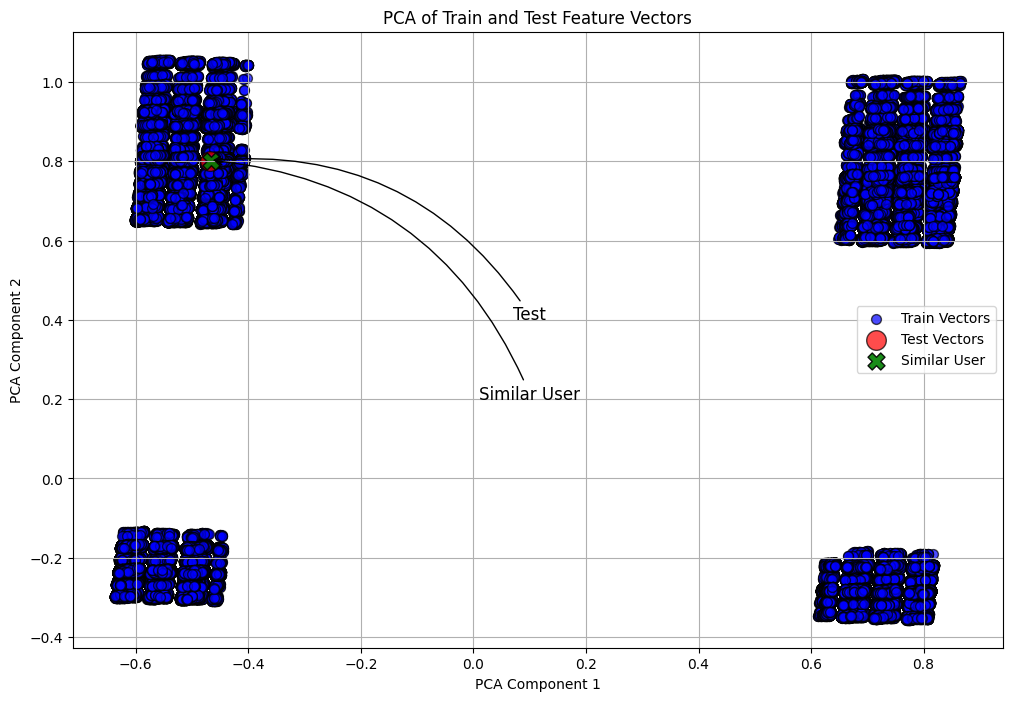

----------------------------------------------------------
Predicted value: |Aldi - Lodge Farms - Free Range Eggs 700g 1 Egg, 1 Egg 52g|
----------------------------------------------------------
Actual values: |Gatorade - Lemon-Lime (Australia), 600 ml|
----------------------------------------------------------
R square score is: 0.8247303368203538
----------------------------------------------------------


In [29]:
testing('/content/drive/MyDrive/Final Project/mfp-diaries.tsv', 167, 1, plot=True)

In [30]:
testing('/content/drive/MyDrive/Final Project/mfp-diaries.tsv', 237, 1, recommended_items=10, plot=False)

----------------------------------------------------------
Predicted values: 
1 - Kraft - Smooth Peanut Butter (Canada), 1 Tbsp
2 - Generic - Tea With 2% & Skimmed Milk, 2 Cup
3 - Bruegger's Bagels - Everything Bagel, 0.5 bagel
4 - Oscar Myer Bacon - Naturally Hardwood Smoked 17 g Serving, 2 slices (17g)
5 - Market Basket - 1/3less Fat Than Cream Cheese - Neufchatel Cheese, 1 Oz
6 - Eggs Large - Fried Over Medium, 1 eggs
7 - General Mills - Cheerios - Multi Grain - Dark Chocolate Crunch - Dry, 0.9750000000000001 cup (28g)
8 - Nutragrain - Strawberry Cereal Bar, 1 bar
9 - Chia Squeeze - Blackberry Bliss, 1 pouch
10 - Fiber One - Meal Bar Chcolate Peanut Butter, 1 Bar
----------------------------------------------------------
Actual values: |Cereals - Oats, regular and quick and instant, unenriched, cooked with water, without salt (oatmeal), 0.5 cup|
----------------------------------------------------------
R square score is: 0.9997141973615467
------------------------------------------